[1/3] Starting Feature Extraction Process...
   📂 Data sources: ['../../data/raw', '../../data/raw2']
   🎵 Moods to process: ['angry', 'happy', 'relaxed', 'sad']

[2/3] Analyzing Audio Features (Full Song)...
⚠️ ATTENTION: This process will take time as it reads the full duration of all songs.
   🎵 angry: Processing 50 songs...
      ...processing song 5 of 50
      ...processing song 10 of 50
      ...processing song 15 of 50
      ...processing song 20 of 50
      ...processing song 25 of 50
      ...processing song 30 of 50
      ...processing song 35 of 50
      ...processing song 40 of 50
      ...processing song 45 of 50
      ...processing song 50 of 50
   🎵 happy: Processing 50 songs...
      ...processing song 5 of 50
      ...processing song 10 of 50
      ...processing song 15 of 50
      ...processing song 20 of 50
      ...processing song 25 of 50
      ...processing song 30 of 50
      ...processing song 35 of 50
      ...processing song 40 of 50
      ...processing song 

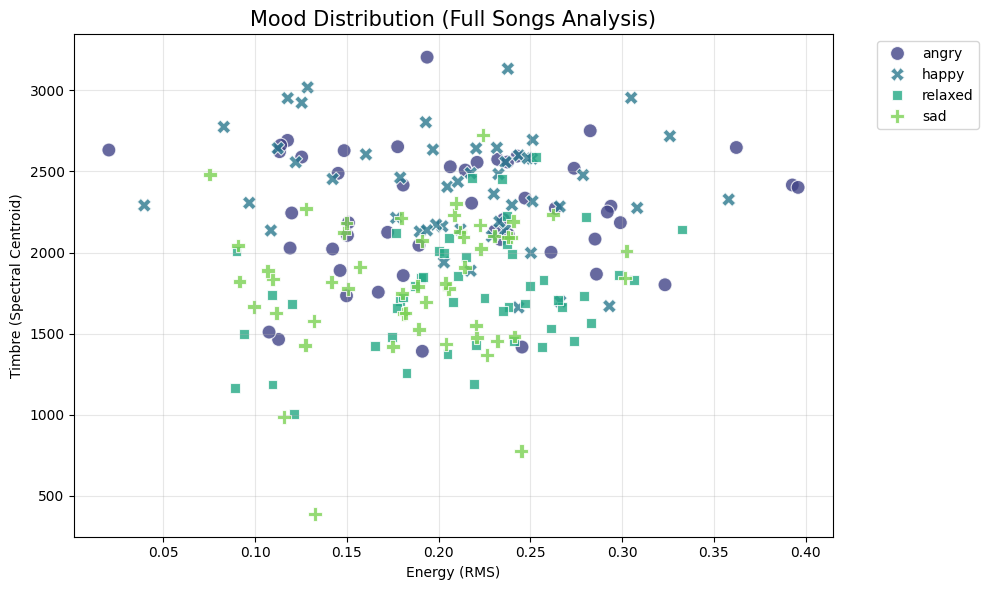

In [1]:
# ==============================================================================
# FINAL PROJECT AUDIO ANALYSIS: FULL DURATION & ALL SONGS
# ==============================================================================

import os
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 1. PATH CONFIGURATION
# ==============================================================================
print("[1/3] Starting Feature Extraction Process...")

DATA_PATHS = ["../../data/raw", "../../data/raw2"]
MOODS = ["angry", "happy", "relaxed", "sad"]

print(f"   📂 Data sources: {DATA_PATHS}")
print(f"   🎵 Moods to process: {MOODS}")

# 2. AUDIO FEATURE ANALYSIS (FULL VERSION)
# ==============================================================================
print("\n[2/3] Analyzing Audio Features (Full Song)...")
print("⚠️ ATTENTION: This process will take time as it reads the full duration of all songs.")

features = []

for mood in MOODS:
    audio_files = []
    for dp in DATA_PATHS:
        search_path = os.path.join(dp, mood, '**')
        files = glob.glob(search_path + '/*.mp3', recursive=True) + \
                glob.glob(search_path + '/*.wav', recursive=True)
        audio_files.extend(files)

    total_files = len(audio_files)
    if total_files == 0:
        print(f"   ⚠️ No files found for mood: {mood}")
        continue

    print(f"   🎵 {mood}: Processing {total_files} songs...")

    # Loop ALL songs
    for i, filepath in enumerate(audio_files):
        try:
            # Show progress every 5 songs
            if (i+1) % 5 == 0:
                print(f"      ...processing song {i+1} of {total_files}")

            # Load FULL DURATION
            y, sr = librosa.load(filepath)

            # A. TEMPO (BPM)
            tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
            if isinstance(tempo, np.ndarray): tempo = tempo[0]

            # B. ENERGY (RMS)
            rms = librosa.feature.rms(y=y)[0]
            avg_energy = np.mean(rms)

            # C. TIMBRE (Spectral Centroid)
            cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            avg_timbre = np.mean(cent)

            features.append({
                'Mood': mood,
                'Tempo (BPM)': tempo,
                'Energy (RMS)': avg_energy,
                'Timbre (Centroid)': avg_timbre
            })
        except Exception as e:
            print(f"      ❌ Error in file {os.path.basename(filepath)}: {e}")

# 3. VISUALIZATION OF RESULTS
# ==============================================================================
if len(features) > 0:
    df = pd.DataFrame(features)

    print("\n✅ FINAL DATA SUCCESSFULLY COLLECTED!")
    print(df.groupby('Mood').mean(numeric_only=True))

    # Save to CSV
    df.to_csv('final_audio_features_full_raw.csv', index=False)
    print("   CSV file saved: final_audio_features_full_raw.csv")

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x='Energy (RMS)',
        y='Timbre (Centroid)',
        hue='Mood',
        style='Mood',
        s=100,
        palette='viridis',
        alpha=0.8
    )

    plt.title('Mood Distribution (Full Songs Analysis)', fontsize=15)
    plt.xlabel('Energy (RMS)')
    plt.ylabel('Timbre (Spectral Centroid)')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("\n❌ No data collected. Please check your data paths.")

**Scatter Plot Interpretation**

This is the goal of EDA. Look at the colorful graph generated above.

**If Data Points Cluster:**

Example: Angry points (e.g., Purple) cluster in the top right corner (High Energy, High Timbre).

Example: Sad points (e.g., Green) cluster in the bottom left corner (Low Energy, Low Timbre).

**Conclusion:**

"Looking at the graph, the Angry mood points are far separated from the Sad mood points. This means the features we chose (Energy & Timbre) are ALREADY GOOD."

"Because the data is visually separated, Machine Learning algorithms (such as XGBoost or Random Forest) will easily draw boundary lines to distinguish between songs."

**From EDA to Machine Learning (Final)**

How do these numbers become ML?

**CSV File**: The final result is a CSV file (`final_audio_features_full_raw.csv`). This file no longer contains .mp3 files, but a table:
| Filename | Energy | Timbre | Tempo | Label (Target) |
| :--- | :--- | :--- | :--- | :--- |
| angry1.mp3 | 0.85 | 4000 | 140 | angry |
| sad1.mp3 | 0.20 | 1200 | 70 | sad |

**Training**: You will "feed" this table to the AI model.

**Pattern Learning**: The AI will learn rules: "Oh, if Energy > 0.8 and Timbre > 3500, then this is definitely ANGRY."

**Prediction**: When a new song comes in, the AI extracts its numbers, matches them with those rules, and guesses its mood.

# EXPLANATION (What are these numbers?)

**A. Energy (RMS - Root Mean Square) -> Represents "Arousal"**

**Definition**: Measures how "loud" or "intense" the average sound volume is in a song.

**How Librosa Works**: It calculates the amplitude (the height of the waves) every millisecond, then averages them.

**Human Logic**:

Angry songs (e.g., Metal/Rock) definitely involve shouting & full instrumentation = High Energy.

Sad songs (e.g., Piano/Acoustic) are usually quiet & subtle = Low Energy.

Relaxed songs (e.g., Lofi) = Low/Medium Energy.

**Connection to ML**: This feature separates the X-axis (Left vs. Right).

**B. Timbre (Spectral Centroid) -> Represents Sound Color (Valence Proxy)**

**Definition**: The center of mass of the sound spectrum. Often called sound "brightness."

**How Librosa Works**: Uses Fourier Transform to break sound down into frequencies.

**Human Logic**:

Bright/Sharp Sound: Guitar distortion, drum cymbals, shouting, high-pitched sounds = High Centroid (Usually Angry/Happy).

Dark/Heavy Sound: Bass, cello, muffled sound, low piano = Low Centroid (Usually Sad/Relaxed).

**Connection to ML**: This feature helps distinguish emotions that have the same energy but different "feel" (e.g., Happy vs. Angry).

**C. Tempo (BPM - Beats Per Minute)**

**Definition**: The speed of the song's beat.

**How Librosa Works**: Detects onsets (the starting attack of drum/bass sounds) that repeat periodically.

**Human Logic**:

Happy/Angry: Usually fast-paced (>120 BPM).

Sad/Relaxed: Usually slow-paced (<90 BPM).